In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm.autonotebook import tqdm

from esn_module import esn

from echo_state_tests import gen_in_out_one_in_subs

from echo_state_tests import test_XOR

from scipy.sparse import csr_matrix, issparse

from tqdm import tqdm_notebook as tqdm

/home/fschubert/work/py35/lib/python3.5/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [195]:
def run_simulation(u_in,
                    N=1000,
                  cf=.1,
                  cf_in=1.,
                  sigm_w=1.,
                  sigm_w_in=1.,
                  a=np.ones((1000)),
                  b=np.zeros((1000)),
                  y_m_t = np.ones((1000))*(0.),
                   y_squ_t = np.ones((1000))*0.25,
                  eps_y_m = 0.005,
                    eps_y_squ_m = 0.005,
                    eps_y_squ_t = 0.005,
                    eps_a = 0.005,
                    eps_b = 0.005,
                  T_skip_rec=10):

    ### Init Connections
    W = np.random.normal(0.,sigm_w/(cf*N)**.5,(N,N))*(np.random.rand(N,N)<=cf)
    W[range(N),range(N)] = 0.

    W_T_squ = W.T**2.

    if cf < .5:
        W = csr_matrix(W)

    w_in = np.random.normal(0.,sigm_w_in,(N))*(np.random.rand(N)<=cf_in)
    
    #w_in = np.ones((N))
    
    
    ### Running Averages
    y_m = np.zeros((N))
    y_squ_m = np.ones((N))*0.25

    ### Running Time
    T = u_in.shape[0]
    T_rec = int(T/T_skip_rec)

    ### recording Arrays
    y_rec = np.ndarray((T_rec,N))

    y_m_rec = np.ndarray((T_rec,N))
    y_squ_m_rec = np.ndarray((T_rec,N))

    a_rec = np.ndarray((T_rec,N))
    b_rec = np.ndarray((T_rec,N))

    y_squ_t_rec = np.ndarray((T_rec,N))

    v_rec = np.ndarray((T_rec))

    ### Init Network State
    y = np.random.rand(N)-.5

    ### Run Simulation
    for t in tqdm(range(T)):

        #y = np.exp(a*(W.dot(y) + w_in*u_in[t] - b))
        y = np.tanh(a*(W.dot(y) + w_in*u_in[t] - b))

        y_m += eps_y_m * (y - y_m)
        y_squ_m += eps_y_squ_m * (y**2. - y_squ_m)

        v = (W_T_squ*a**2.).mean()*N

        y_squ_t += eps_y_squ_t * y_squ_t * (1.-y_squ_t) * (1.-v)

        a += eps_a * a * (y_squ_t - y**2.)
        b += eps_b * (y - y_m_t)

        t_rec = int(t/T_skip_rec)

        ### Recording
        y_rec[t_rec,:] = y
        y_m_rec[t_rec,:] = y_m
        y_squ_m_rec[t_rec,:] = y_squ_m

        y_squ_t_rec[t_rec,:] = y_squ_t

        a_rec[t_rec,:] = a
        b_rec[t_rec,:] = b

        v_rec[t_rec] = v
        
    ESN = esn()
    ESN.W = W
    ESN.w_in = np.array([w_in]).T
    ESN.gain = a
    ESN.bias = b
                
    return W,w_in,y_rec,y_m_rec,y_squ_m_rec,a_rec,b_rec,y_squ_t_rec,v_rec,ESN

In [196]:
u_in,u_out = gen_in_out_one_in_subs(10000,5)
u_in = u_in * 0.1 / u_in.std()

mu = 0.2
sigm = 0.05

alpha = mu*(mu*(1.-mu)/sigm**2.-1.)
beta = (1.-mu)*(mu*(1.-mu)/sigm**2.-1.)

squ_targets = np.random.beta(alpha,beta,(1000))

[W,
w_in,
y_rec,
y_m_rec,
y_squ_m_rec,
a_rec,
b_rec,
y_squ_t_rec,
v_rec,
ESN] = run_simulation(u_in, eps_b=0., y_m_t = np.ones((1000))*(0.1),cf_in=0.1)#,y_squ_t = squ_targets)

In [197]:
### Calc Eigvals before and after Simulation
if issparse(W):
    lpre = np.linalg.eigvals(np.array(W.todense()).T*a_rec[0,:])
    lpost = np.linalg.eigvals(np.array(W.todense()).T*a_rec[-1,:])
else:
    lpre = np.linalg.eigvals(W.T*a_rec[0,:])
    lpost = np.linalg.eigvals(W.T*a_rec[-1,:])

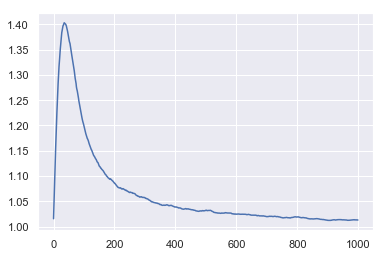

In [198]:
plt.plot(v_rec)
plt.show()

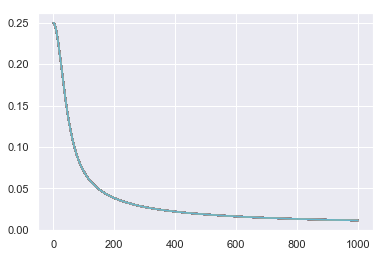

In [199]:
plt.plot(y_squ_t_rec[:,:100])
plt.show()

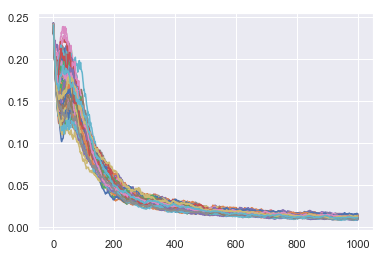

In [200]:
plt.plot(y_squ_m_rec[:,:100])
plt.show()

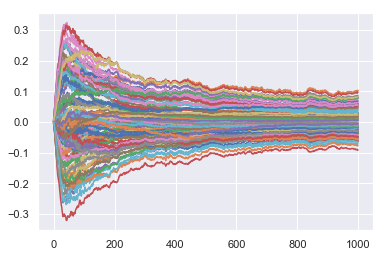

In [201]:
plt.plot(y_m_rec[:,:100])
plt.show()

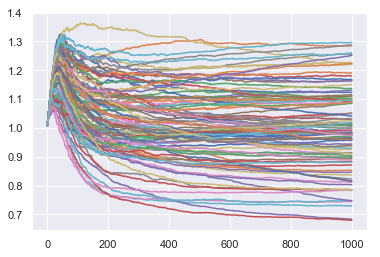

In [202]:
plt.plot(a_rec[:,:100])
plt.show()

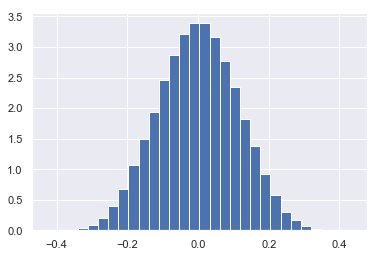

In [203]:
plt.hist(np.reshape(y_rec[-200:,:],(200*ESN.N)),bins=30,density=True)
plt.show()

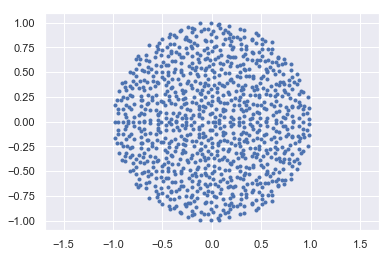

In [204]:
#plt.plot(lpre.real,lpre.imag,'.')
plt.plot(lpost.real,lpost.imag,'.')
plt.axis("equal")
plt.show()

In [206]:
ESN_non_adapt = esn(cf_w_in=0.1)
ESN_manual_adapt = esn(cf_w_in=0.1)

a = np.ones((1000))
#a[:50] = 2.
#a[:10] = 3.
a = .95*a/(a**2.).mean()**.5

print((a**2.).mean())

ESN_manual_adapt.gain = a

0.9025


In [207]:
MC = test_XOR(ESN,40,5000,0.01,10,u_in.std())
MC_non_adapt = test_XOR(ESN_non_adapt,40,5000,0.01,10,u_in.std())
MC_manual_adapt = test_XOR(ESN_manual_adapt,40,5000,0.01,10,u_in.std())

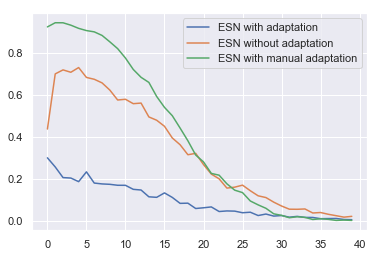

In [208]:
plt.plot(MC[0],label="ESN with adaptation")
plt.plot(MC_non_adapt[0],label="ESN without adaptation")
plt.plot(MC_manual_adapt[0],label="ESN with manual adaptation")
plt.legend()
plt.show()

In [209]:
print(MC[1])
print(MC_non_adapt[1])
print(MC_manual_adapt[1])

3.8077806572647632
13.064984073122066
16.178187393553824


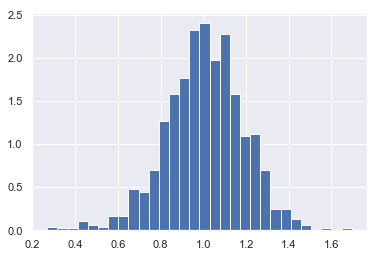

In [210]:
plt.hist(a_rec[-1,:],bins=30,density=True)
plt.show()